In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Load Data
train = pd.read_csv("/kaggle/input/network-intrusion-detection/Train_data.csv")
test = pd.read_csv("/kaggle/input/network-intrusion-detection/Test_data.csv")

print(train.head(4))

print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))

print(test.head(4))

print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

Using TensorFlow backend.


   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0             

In [2]:
#Exploratory Analysis
# Descriptive statistics
train.describe()

print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

#'num_outbound_cmds' is a redundant column so remove it from both train & test datasets
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

# Attack Class Distribution
train['class'].value_counts()


0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


normal     13449
anomaly    11743
Name: class, dtype: int64

In [3]:
#Scalling numerical attributes
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [4]:
#Encoding categorical attributes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [5]:
#Union of processed numerical and categorical data
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = cat_Ytrain
train_x.shape

test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

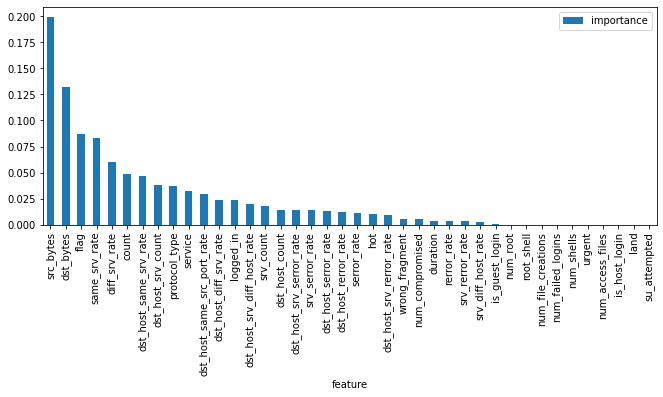

In [6]:
#Feature Selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [7]:
#Recursive feature elimination
from sklearn.feature_selection import RFE
import itertools

rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_srv_serror_rate',
 'protocol_type',
 'service',
 'flag']

In [8]:
a = [i[0] for i in feature_map]

train_x = train_x.iloc[:,a]
test_df = test_df.iloc[:,a]

In [9]:
#Dataset Partition
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)

#Fitting Models
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))

# Adding the second hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, Y_train, batch_size = 10, epochs = 100)

Epoch 1/100
17634/17634 [==============================] - 6s 359us/step - loss: 0.2448 - accuracy: 0.9132
Epoch 2/100
17634/17634 [==============================] - 5s 305us/step - loss: 0.1604 - accuracy: 0.9357
Epoch 3/100
17634/17634 [==============================] - 5s 297us/step - loss: 0.1575 - accuracy: 0.9362
Epoch 4/100
17634/17634 [==============================] - 6s 329us/step - loss: 0.1548 - accuracy: 0.9392
Epoch 5/100
17634/17634 [==============================] - 5s 306us/step - loss: 0.1539 - accuracy: 0.9393
Epoch 6/100
17634/17634 [==============================] - 6s 331us/step - loss: 0.1529 - accuracy: 0.9386
Epoch 7/100
17634/17634 [==============================] - 6s 315us/step - loss: 0.1526 - accuracy: 0.9394
Epoch 8/100
17634/17634 [==============================] - 6s 312us/step - loss: 0.1506 - accuracy: 0.9399
Epoch 9/100
17634/17634 [==============================] - 5s 304us/step - loss: 0.1485 - accuracy: 0.9399
Epoch 10/100
17634/17634 [===========

Epoch 77/100
17634/17634 [==============================] - 5s 303us/step - loss: 0.0670 - accuracy: 0.9769
Epoch 78/100
17634/17634 [==============================] - 5s 298us/step - loss: 0.0668 - accuracy: 0.9766
Epoch 79/100
17634/17634 [==============================] - 5s 291us/step - loss: 0.0665 - accuracy: 0.9755
Epoch 80/100
17634/17634 [==============================] - 5s 302us/step - loss: 0.0668 - accuracy: 0.9761
Epoch 81/100
17634/17634 [==============================] - 5s 291us/step - loss: 0.0661 - accuracy: 0.9774
Epoch 82/100
17634/17634 [==============================] - 5s 310us/step - loss: 0.0667 - accuracy: 0.9763
Epoch 83/100
17634/17634 [==============================] - 5s 308us/step - loss: 0.0652 - accuracy: 0.9760
Epoch 84/100
17634/17634 [==============================] - 6s 317us/step - loss: 0.0653 - accuracy: 0.9769
Epoch 85/100
17634/17634 [==============================] - 6s 327us/step - loss: 0.0651 - accuracy: 0.9769
Epoch 86/100
17634/17634 [==

In [10]:
yhat_train = (classifier.predict(X_train) > 0.5)
yhat_test = (classifier.predict(X_test) > 0.5)

In [11]:
# PREDICTING FOR TEST DATA
pred_ann = classifier.predict(test_df)

In [12]:
#Evaluate Models
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier

def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100)

scores = cross_val_score(estimator = classifier,X = X_train, y = Y_train, cv = 10, n_jobs = 1)#should be n_jobs = -1, but seems like kaggle doesn`t give more than one CPU

Epoch 1/100
15870/15870 [==============================] - 5s 311us/step - loss: 0.2397 - accuracy: 0.9091
Epoch 2/100
15870/15870 [==============================] - 5s 307us/step - loss: 0.1480 - accuracy: 0.9445
Epoch 3/100
15870/15870 [==============================] - 5s 294us/step - loss: 0.1368 - accuracy: 0.9499
Epoch 4/100
15870/15870 [==============================] - 5s 311us/step - loss: 0.1293 - accuracy: 0.9546
Epoch 5/100
15870/15870 [==============================] - 5s 302us/step - loss: 0.1236 - accuracy: 0.9567
Epoch 6/100
15870/15870 [==============================] - 5s 296us/step - loss: 0.1192 - accuracy: 0.9582
Epoch 7/100
15870/15870 [==============================] - 5s 344us/step - loss: 0.1146 - accuracy: 0.9601
Epoch 8/100
15870/15870 [==============================] - 5s 328us/step - loss: 0.1112 - accuracy: 0.9614
Epoch 9/100
15870/15870 [==============================] - 5s 308us/step - loss: 0.1087 - accuracy: 0.9629
Epoch 10/100
15870/15870 [===========

Epoch 77/100
15870/15870 [==============================] - 5s 306us/step - loss: 0.0720 - accuracy: 0.9766
Epoch 78/100
15870/15870 [==============================] - 5s 312us/step - loss: 0.0725 - accuracy: 0.9762
Epoch 79/100
15870/15870 [==============================] - 5s 304us/step - loss: 0.0719 - accuracy: 0.9764
Epoch 80/100
15870/15870 [==============================] - 6s 350us/step - loss: 0.0718 - accuracy: 0.9757
Epoch 81/100
15870/15870 [==============================] - 5s 320us/step - loss: 0.0719 - accuracy: 0.9759
Epoch 82/100
15870/15870 [==============================] - 5s 313us/step - loss: 0.0713 - accuracy: 0.9767
Epoch 83/100
15870/15870 [==============================] - 5s 301us/step - loss: 0.0723 - accuracy: 0.9764
Epoch 84/100
15870/15870 [==============================] - 5s 299us/step - loss: 0.0724 - accuracy: 0.9759
Epoch 85/100
15870/15870 [==============================] - 5s 307us/step - loss: 0.0714 - accuracy: 0.9766
Epoch 86/100
15870/15870 [==

15870/15870 [==============================] - 5s 315us/step - loss: 0.0690 - accuracy: 0.9739
Epoch 53/100
15870/15870 [==============================] - 5s 320us/step - loss: 0.0686 - accuracy: 0.9739
Epoch 54/100
15870/15870 [==============================] - 5s 309us/step - loss: 0.0674 - accuracy: 0.9745
Epoch 55/100
15870/15870 [==============================] - 5s 336us/step - loss: 0.0670 - accuracy: 0.9745
Epoch 56/100
15870/15870 [==============================] - 5s 310us/step - loss: 0.0676 - accuracy: 0.9752
Epoch 57/100
15870/15870 [==============================] - 5s 323us/step - loss: 0.0668 - accuracy: 0.9747
Epoch 58/100
15870/15870 [==============================] - 5s 311us/step - loss: 0.0663 - accuracy: 0.9752
Epoch 59/100
15870/15870 [==============================] - 5s 334us/step - loss: 0.0667 - accuracy: 0.9750
Epoch 60/100
15870/15870 [==============================] - 5s 317us/step - loss: 0.0653 - accuracy: 0.9750
Epoch 61/100
15870/15870 [===============

15870/15870 [==============================] - 5s 301us/step - loss: 0.0889 - accuracy: 0.9728
Epoch 28/100
15870/15870 [==============================] - 5s 313us/step - loss: 0.0882 - accuracy: 0.9727
Epoch 29/100
15870/15870 [==============================] - 5s 309us/step - loss: 0.0881 - accuracy: 0.9723
Epoch 30/100
15870/15870 [==============================] - 5s 314us/step - loss: 0.0878 - accuracy: 0.9723
Epoch 31/100
15870/15870 [==============================] - 5s 319us/step - loss: 0.0871 - accuracy: 0.9716
Epoch 32/100
15870/15870 [==============================] - 5s 346us/step - loss: 0.0852 - accuracy: 0.9720
Epoch 33/100
15870/15870 [==============================] - 5s 341us/step - loss: 0.0854 - accuracy: 0.9721
Epoch 34/100
15870/15870 [==============================] - 5s 306us/step - loss: 0.0836 - accuracy: 0.9729
Epoch 35/100
15870/15870 [==============================] - 5s 314us/step - loss: 0.0847 - accuracy: 0.9719
Epoch 36/100
15870/15870 [===============

15870/15870 [==============================] - 5s 327us/step - loss: 0.1391 - accuracy: 0.9531
Epoch 3/100
15870/15870 [==============================] - 5s 330us/step - loss: 0.1286 - accuracy: 0.9561
Epoch 4/100
15870/15870 [==============================] - 5s 340us/step - loss: 0.1241 - accuracy: 0.9575
Epoch 5/100
15870/15870 [==============================] - 5s 312us/step - loss: 0.1191 - accuracy: 0.9582
Epoch 6/100
15870/15870 [==============================] - 5s 311us/step - loss: 0.1149 - accuracy: 0.9604
Epoch 7/100
15870/15870 [==============================] - 5s 301us/step - loss: 0.1122 - accuracy: 0.9616
Epoch 8/100
15870/15870 [==============================] - 5s 318us/step - loss: 0.1096 - accuracy: 0.9624
Epoch 9/100
15870/15870 [==============================] - 5s 313us/step - loss: 0.1063 - accuracy: 0.9633
Epoch 10/100
15870/15870 [==============================] - 5s 302us/step - loss: 0.1030 - accuracy: 0.9645
Epoch 11/100
15870/15870 [======================

15870/15870 [==============================] - 5s 300us/step - loss: 0.0552 - accuracy: 0.9800
Epoch 79/100
15870/15870 [==============================] - 5s 309us/step - loss: 0.0571 - accuracy: 0.9797
Epoch 80/100
15870/15870 [==============================] - 5s 312us/step - loss: 0.0556 - accuracy: 0.9803
Epoch 81/100
15870/15870 [==============================] - 5s 313us/step - loss: 0.0550 - accuracy: 0.9801
Epoch 82/100
15870/15870 [==============================] - 5s 303us/step - loss: 0.0549 - accuracy: 0.9802
Epoch 83/100
15870/15870 [==============================] - 5s 303us/step - loss: 0.0549 - accuracy: 0.9810
Epoch 84/100
15870/15870 [==============================] - 5s 314us/step - loss: 0.0556 - accuracy: 0.9807
Epoch 85/100
15870/15870 [==============================] - 5s 302us/step - loss: 0.0554 - accuracy: 0.9799
Epoch 86/100
15870/15870 [==============================] - 5s 313us/step - loss: 0.0559 - accuracy: 0.9810
Epoch 87/100
15870/15870 [===============

15871/15871 [==============================] - 5s 308us/step - loss: 0.0603 - accuracy: 0.9798
Epoch 54/100
15871/15871 [==============================] - 5s 309us/step - loss: 0.0610 - accuracy: 0.9793
Epoch 55/100
15871/15871 [==============================] - 5s 311us/step - loss: 0.0596 - accuracy: 0.9789
Epoch 56/100
15871/15871 [==============================] - 5s 305us/step - loss: 0.0606 - accuracy: 0.9797
Epoch 57/100
15871/15871 [==============================] - 5s 313us/step - loss: 0.0597 - accuracy: 0.9796
Epoch 58/100
15871/15871 [==============================] - 5s 300us/step - loss: 0.0596 - accuracy: 0.9791
Epoch 59/100
15871/15871 [==============================] - 5s 329us/step - loss: 0.0592 - accuracy: 0.9797
Epoch 60/100
15871/15871 [==============================] - 5s 315us/step - loss: 0.0598 - accuracy: 0.9792
Epoch 61/100
15871/15871 [==============================] - 5s 332us/step - loss: 0.0591 - accuracy: 0.9783
Epoch 62/100
15871/15871 [===============

15871/15871 [==============================] - 5s 306us/step - loss: 0.0754 - accuracy: 0.9748
Epoch 29/100
15871/15871 [==============================] - 5s 295us/step - loss: 0.0760 - accuracy: 0.9752
Epoch 30/100
15871/15871 [==============================] - 5s 308us/step - loss: 0.0751 - accuracy: 0.9754
Epoch 31/100
15871/15871 [==============================] - 5s 296us/step - loss: 0.0738 - accuracy: 0.9753
Epoch 32/100
15871/15871 [==============================] - 5s 305us/step - loss: 0.0734 - accuracy: 0.9754
Epoch 33/100
15871/15871 [==============================] - 5s 323us/step - loss: 0.0719 - accuracy: 0.9754
Epoch 34/100
15871/15871 [==============================] - 5s 314us/step - loss: 0.0705 - accuracy: 0.9767
Epoch 35/100
15871/15871 [==============================] - 5s 316us/step - loss: 0.0708 - accuracy: 0.9754
Epoch 36/100
15871/15871 [==============================] - 5s 297us/step - loss: 0.0692 - accuracy: 0.9765
Epoch 37/100
15871/15871 [===============

15871/15871 [==============================] - 5s 304us/step - loss: 0.1365 - accuracy: 0.9528
Epoch 4/100
15871/15871 [==============================] - 5s 289us/step - loss: 0.1318 - accuracy: 0.9544
Epoch 5/100
15871/15871 [==============================] - 5s 311us/step - loss: 0.1277 - accuracy: 0.9565
Epoch 6/100
15871/15871 [==============================] - 5s 300us/step - loss: 0.1260 - accuracy: 0.9572
Epoch 7/100
15871/15871 [==============================] - 5s 322us/step - loss: 0.1209 - accuracy: 0.9592
Epoch 8/100
15871/15871 [==============================] - 5s 328us/step - loss: 0.1192 - accuracy: 0.9598
Epoch 9/100
15871/15871 [==============================] - 5s 303us/step - loss: 0.1154 - accuracy: 0.9615
Epoch 10/100
15871/15871 [==============================] - 5s 313us/step - loss: 0.1146 - accuracy: 0.9611
Epoch 11/100
15871/15871 [==============================] - 5s 294us/step - loss: 0.1121 - accuracy: 0.9626
Epoch 12/100
15871/15871 [=====================

15871/15871 [==============================] - 5s 300us/step - loss: 0.0662 - accuracy: 0.9776
Epoch 80/100
15871/15871 [==============================] - 5s 317us/step - loss: 0.0643 - accuracy: 0.9786
Epoch 81/100
15871/15871 [==============================] - 5s 291us/step - loss: 0.0624 - accuracy: 0.9793
Epoch 82/100
15871/15871 [==============================] - 5s 291us/step - loss: 0.0636 - accuracy: 0.9785
Epoch 83/100
15871/15871 [==============================] - 5s 308us/step - loss: 0.0621 - accuracy: 0.9791
Epoch 84/100
15871/15871 [==============================] - 5s 316us/step - loss: 0.0647 - accuracy: 0.9780
Epoch 85/100
15871/15871 [==============================] - 5s 299us/step - loss: 0.0626 - accuracy: 0.9775
Epoch 86/100
15871/15871 [==============================] - 5s 303us/step - loss: 0.0625 - accuracy: 0.9785
Epoch 87/100
15871/15871 [==============================] - 5s 304us/step - loss: 0.0618 - accuracy: 0.9788
Epoch 88/100
15871/15871 [===============

15871/15871 [==============================] - 5s 301us/step - loss: 0.0688 - accuracy: 0.9738
Epoch 55/100
15871/15871 [==============================] - 5s 305us/step - loss: 0.0694 - accuracy: 0.9745
Epoch 56/100
15871/15871 [==============================] - 5s 293us/step - loss: 0.0680 - accuracy: 0.9742
Epoch 57/100
15871/15871 [==============================] - 5s 303us/step - loss: 0.0678 - accuracy: 0.9746
Epoch 58/100
15871/15871 [==============================] - 5s 324us/step - loss: 0.0679 - accuracy: 0.9745
Epoch 59/100
15871/15871 [==============================] - 5s 306us/step - loss: 0.0684 - accuracy: 0.9745
Epoch 60/100
15871/15871 [==============================] - 5s 293us/step - loss: 0.0672 - accuracy: 0.9749
Epoch 61/100
15871/15871 [==============================] - 5s 300us/step - loss: 0.0678 - accuracy: 0.9753
Epoch 62/100
15871/15871 [==============================] - 5s 297us/step - loss: 0.0662 - accuracy: 0.9763
Epoch 63/100
15871/15871 [===============

15871/15871 [==============================] - 5s 304us/step - loss: 0.0743 - accuracy: 0.9749
Epoch 30/100
15871/15871 [==============================] - 5s 318us/step - loss: 0.0745 - accuracy: 0.9741
Epoch 31/100
15871/15871 [==============================] - 5s 300us/step - loss: 0.0724 - accuracy: 0.9745
Epoch 32/100
15871/15871 [==============================] - 5s 327us/step - loss: 0.0726 - accuracy: 0.9748
Epoch 33/100
15871/15871 [==============================] - 5s 333us/step - loss: 0.0716 - accuracy: 0.9753
Epoch 34/100
15871/15871 [==============================] - 5s 310us/step - loss: 0.0726 - accuracy: 0.9743
Epoch 35/100
15871/15871 [==============================] - 5s 315us/step - loss: 0.0699 - accuracy: 0.9750
Epoch 36/100
15871/15871 [==============================] - 5s 298us/step - loss: 0.0693 - accuracy: 0.9762
Epoch 37/100
15871/15871 [==============================] - 5s 310us/step - loss: 0.0685 - accuracy: 0.9776
Epoch 38/100
15871/15871 [===============

15871/15871 [==============================] - 5s 301us/step - loss: 0.1135 - accuracy: 0.9617
Epoch 5/100
15871/15871 [==============================] - 5s 290us/step - loss: 0.1050 - accuracy: 0.9638
Epoch 6/100
15871/15871 [==============================] - 5s 321us/step - loss: 0.0996 - accuracy: 0.9652
Epoch 7/100
15871/15871 [==============================] - 5s 314us/step - loss: 0.0942 - accuracy: 0.9677
Epoch 8/100
15871/15871 [==============================] - 5s 316us/step - loss: 0.0911 - accuracy: 0.9672
Epoch 9/100
15871/15871 [==============================] - 5s 300us/step - loss: 0.0894 - accuracy: 0.9681
Epoch 10/100
15871/15871 [==============================] - 5s 293us/step - loss: 0.0873 - accuracy: 0.9701
Epoch 11/100
15871/15871 [==============================] - 5s 304us/step - loss: 0.0864 - accuracy: 0.9700
Epoch 12/100
15871/15871 [==============================] - 5s 297us/step - loss: 0.0831 - accuracy: 0.9718
Epoch 13/100
15871/15871 [====================

15871/15871 [==============================] - 5s 296us/step - loss: 0.0525 - accuracy: 0.9811
Epoch 81/100
15871/15871 [==============================] - 5s 313us/step - loss: 0.0527 - accuracy: 0.9815
Epoch 82/100
15871/15871 [==============================] - 5s 330us/step - loss: 0.0556 - accuracy: 0.9808
Epoch 83/100
15871/15871 [==============================] - 5s 303us/step - loss: 0.0514 - accuracy: 0.9819
Epoch 84/100
15871/15871 [==============================] - 5s 298us/step - loss: 0.0506 - accuracy: 0.9827
Epoch 85/100
15871/15871 [==============================] - 5s 291us/step - loss: 0.0529 - accuracy: 0.9811
Epoch 86/100
15871/15871 [==============================] - 5s 298us/step - loss: 0.0503 - accuracy: 0.9817
Epoch 87/100
15871/15871 [==============================] - 5s 290us/step - loss: 0.0509 - accuracy: 0.9809
Epoch 88/100
15871/15871 [==============================] - 5s 291us/step - loss: 0.0528 - accuracy: 0.9825
Epoch 89/100
15871/15871 [===============

In [13]:
accuracy = metrics.accuracy_score(Y_train, yhat_train)
confusion_matrix = metrics.confusion_matrix(Y_train, yhat_train)
classification = metrics.classification_report(Y_train, yhat_train)
print()
print('============================== ANN Model Evaluation ==============================' )
print()
print ("Cross Validation Mean Score:" "\n", scores.mean())
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()


============================== ANN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9814568281173706

Model Accuracy:
 0.9755585800158784

Confusion matrix:
 [[8011  234]
 [ 197 9192]]

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      8245
           1       0.98      0.98      0.98      9389

    accuracy                           0.98     17634
   macro avg       0.98      0.98      0.98     17634
weighted avg       0.98      0.98      0.98     17634




In [14]:
#Validate Models
accuracy = metrics.accuracy_score(Y_test, yhat_test)
confusion_matrix = metrics.confusion_matrix(Y_test, yhat_test)
classification = metrics.classification_report(Y_test, yhat_test)
print()
print('============================== ANN Model Test Results ==============================')
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()        


============================== ANN Model Test Results ==============================

Model Accuracy:
 0.9753903148981212

Confusion matrix:
 [[3400   98]
 [  88 3972]]

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3498
           1       0.98      0.98      0.98      4060

    accuracy                           0.98      7558
   macro avg       0.98      0.98      0.98      7558
weighted avg       0.98      0.98      0.98      7558


